In [1]:
from fastai import *
from fastai.vision import *

from ranger import Ranger

PATH = Path('..').resolve()

%matplotlib inline

In [2]:
sys.path.append(f'{PATH}/src')

from mxresnet import *


flat_np = lambda arr: to_np(arr.reshape(-1))

Mish activation loaded...
Mish activation loaded...


In [3]:
df = pd.read_csv(PATH/'data'/'combined.csv', index_col=0)
df.sample(2)

,id,logfgas
601,AGC_181124,-0.732030
681,GASS_112017,-1.485894


# Train

In [4]:
bs = 32
sz = 224

image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

In [5]:
il = ImageList.from_df(df, path=PATH, folder='images', suffix='.jpg', cols='id')

src = (il.split_by_rand_pct(0.2)
         .label_from_df(cols='logfgas',  label_cls=FloatList)
)

data = (src.transform(tfms, size=sz)
           .databunch(bs=bs)
           .normalize(image_stats)
)

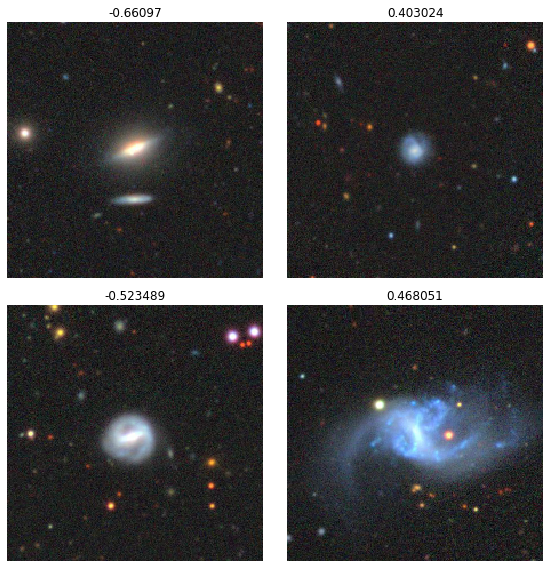

In [15]:
data.show_batch(2)

In [69]:
model = mxresnet18()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True).cuda()

In [70]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-4,
    bn_wd=False,
    true_wd=True,
)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


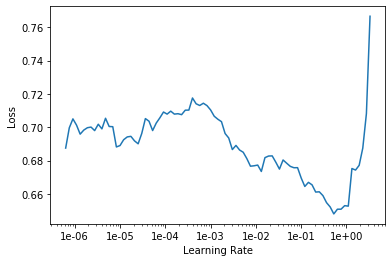

In [71]:
learn.lr_find()
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(30, 3e-2, wd=1e-4)

epoch,train_loss,valid_loss,time
0,0.495787,0.480798,00:22
1,0.384686,0.323077,00:23
2,0.377074,0.478003,00:22
3,0.368593,0.304102,00:22
4,0.366603,0.461778,00:22
5,0.358614,0.315438,00:22
6,0.352421,0.487740,00:22
7,0.358792,0.463550,00:23
8,0.343115,0.515653,00:22
9,0.337585,0.324601,00:22


In [74]:
preds, trues = learn.TTA(scale=1.)

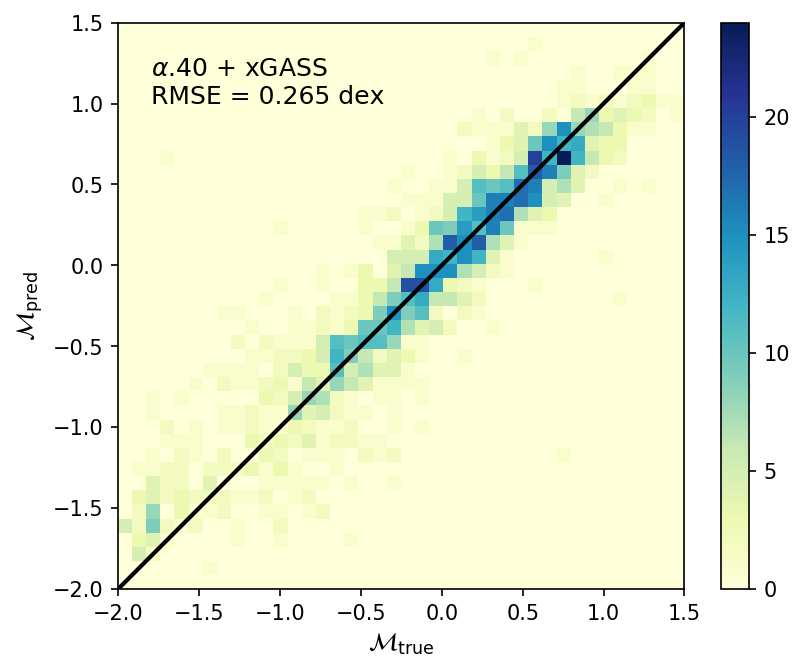

In [79]:
plt.figure(figsize=(6.2, 5), dpi=150)
plt.hist2d(flat_np(trues), flat_np(preds), cmap='YlGnBu', range=[(-2, 1.5), (-2, 1.5)], bins=40);
plt.plot([-2, 2], [-2, 2], c='black', ls='-', lw=2)

plt.gca().set_aspect('equal')
plt.colorbar();

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12);
plt.xticks(np.arange(-2, 2., .5))
plt.yticks(np.arange(-2, 2., .5));

rmse = root_mean_squared_error(trues, preds)
plt.text(-1.8, 1., r'$\alpha$.40 + xGASS' +'\n' + f'RMSE = {rmse:.3f} dex', fontsize=12);


# Deeper model

In [10]:
model = mxresnet50()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True).cuda()

In [11]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-4,
    bn_wd=False,
    true_wd=True,
)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


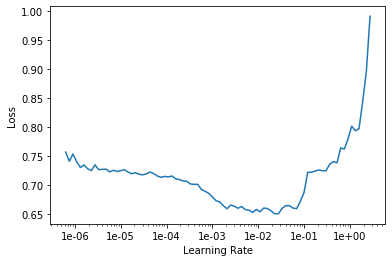

In [8]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(80, 1e-3, wd=1e-4)

epoch,train_loss,valid_loss,time
0,0.568787,0.618014,00:59
1,0.504205,0.495674,00:57
2,0.451492,0.431429,00:57
3,0.432374,0.413282,00:56
4,0.407335,0.424961,00:57
5,0.407027,0.375910,00:57
6,0.373655,0.438075,00:57
7,0.365802,0.384502,00:57
8,0.372334,0.354984,00:57
9,0.360428,0.303974,00:57


In [13]:
# learn.save('combined-mxresnet50_80ep');
learn.load('combined-mxresnet50_80ep');

In [14]:
preds, trues = learn.TTA(scale=1.)

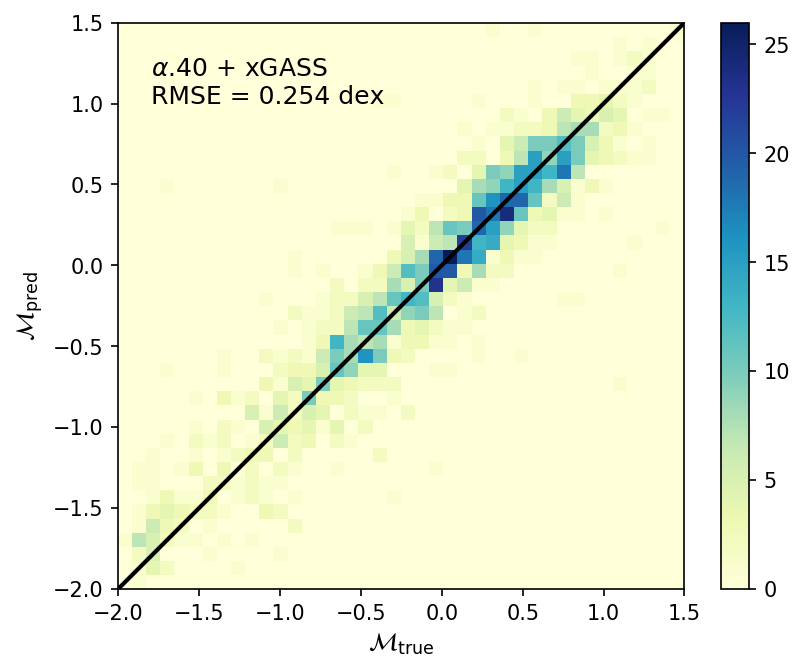

In [15]:
plt.figure(figsize=(6.2, 5), dpi=150)
plt.hist2d(flat_np(trues), flat_np(preds), cmap='YlGnBu', range=[(-2, 1.5), (-2, 1.5)], bins=40);
plt.plot([-2, 2], [-2, 2], c='black', ls='-', lw=2)

plt.gca().set_aspect('equal')
plt.colorbar();

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12);
plt.xticks(np.arange(-2, 2., .5))
plt.yticks(np.arange(-2, 2., .5));

rmse = root_mean_squared_error(trues, preds)
plt.text(-1.8, 1., r'$\alpha$.40 + xGASS' +'\n' + f'RMSE = {rmse:.3f} dex', fontsize=12);


# Test custom methods (will be in `src`)

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

from ranger import Ranger
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

PATH = Path('..').resolve()

sys.path.append(f'{PATH}/src')
from mxresnet import *

Mish activation loaded...
Mish activation loaded...


In [6]:
def get_combined_data(bs=32, sz=224, legacy=False, seed=None):
    df = pd.read_csv(PATH/'data'/'combined.csv', index_col=0)

    if legacy:
        image_stats = []
    else:
        image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]
        
    tfms = get_transforms(
        do_flip=True,
        flip_vert=True,
        max_zoom=1.0,
        max_rotate=15.0,
        max_lighting=0,
        max_warp=0,
    )

    bs = bs
    sz = sz

    il = ImageList.from_df(df, path=PATH, folder='images', suffix='.jpg', cols='id')

    src = (il.split_by_rand_pct(0.2)
             .label_from_df(cols='logfgas',  label_cls=FloatList)
    )

    data = (src.transform(tfms, size=sz)
               .databunch(bs=bs)
               .normalize(image_stats)
    )

    return data



def custom_cnn_learner(
    bs=32, 
    sz=224, 
    legacy=False, 
    cnn_model=mxresnet34, 
    load_model=None
):

    data = get_combined_data(bs=bs, sz=sz, legacy=legacy)

    model = cnn_model()
    model[-1] = nn.Linear(model[-1].in_features, 1, bias=True).cuda()

    learn = Learner(
        data,
        model=model,
        opt_func=partial(Ranger),
        loss_func=root_mean_squared_error,
        wd=1e-4,
        bn_wd=False,
        true_wd=True,
    )

    return learn

In [9]:
learn = custom_cnn_learner(bs=32, sz=224, legacy=False, cnn_model=mxresnet50)

In [10]:
learn.load('combined-mxresnet50_80ep');

set state called
